# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_1537647/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_1537647/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_1537647/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-05 18:03:06,357] A new study created in RDB with name: no-name-4f41afd0-ef4b-4012-8c79-a6fe6f8dd392
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<13:18,  2.50it/s]

current_loss: tensor(1.4604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4538110494613647
current_loss: tensor(1.4568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:40,  9.04it/s]

current_loss_val:  1.429117202758789
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(2.1787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.423114538192749
current_loss: tensor(1.4284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4227206707000732
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.422663688659668


  0%|          | 8/2000 [00:00<02:37, 12.64it/s]

current_loss: tensor(1.4279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.422723650932312
current_loss: tensor(1.4279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4225295782089233
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4223382472991943
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4223531484603882
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:16, 14.59it/s]

current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4222073554992676
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4224656820297241
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4222385883331299
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<01:57, 16.96it/s]

current_loss_val:  1.4224573373794556
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.422086477279663
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4220232963562012
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4218004941940308
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4218988418579102
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:28, 13.29it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4219238758087158
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4219884872436523
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4219374656677246
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4218685626983643
Early Stop at iteration 20 with minimal loss tensor(1.4218, device='cuda:0') and patience 5 and min_delta 1e-07



  0%|          | 1/2000 [00:00<03:36,  9.23it/s]

current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3791242837905884
current_loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3234226703643799
current_loss: tensor(1.3554, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:26,  9.67it/s]

current_loss: tensor(1.3532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3036301136016846
current_loss: tensor(1.3390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2963448762893677
current_loss: tensor(1.3295, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:10, 10.48it/s]

current_loss: tensor(1.3256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.292975902557373
current_loss: tensor(1.3256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2888388633728027
current_loss: tensor(1.3221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:57, 11.25it/s]

current_loss_val:  1.2838256359100342
current_loss: tensor(1.3192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.280944585800171
current_loss: tensor(1.3162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2775782346725464
current_loss: tensor(1.3134, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:54, 11.37it/s]

current_loss: tensor(1.3096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695560455322266
current_loss: tensor(1.3096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676602602005005
current_loss: tensor(1.3061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:54, 11.40it/s]

current_loss_val:  1.2671492099761963
current_loss: tensor(1.3047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639070749282837
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:03, 10.83it/s]

current_loss_val:  1.26323664188385
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262861967086792
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618108987808228
current_loss: tensor(1.2944, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:59, 11.07it/s]

current_loss: tensor(1.2937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617756128311157
current_loss: tensor(1.2937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261791706085205
current_loss: tensor(1.2928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2923, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:57, 11.13it/s]

current_loss_val:  1.2618194818496704
current_loss: tensor(1.2923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618457078933716
current_loss: tensor(1.2919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617554664611816
current_loss: tensor(1.2914, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<02:55, 11.27it/s]

current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261650562286377
current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613996267318726
current_loss: tensor(1.2902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:53, 11.37it/s]

current_loss_val:  1.2610268592834473
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607457637786865
current_loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606890201568604
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:53, 11.38it/s]

current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606343030929565
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605857849121094
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:50, 11.55it/s]

current_loss_val:  1.26016366481781
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596238851547241
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591702938079834
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:53, 11.35it/s]

current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586523294448853
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25766122341156
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<02:53, 11.33it/s]

current_loss_val:  1.2572909593582153
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257230281829834
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569977045059204
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:52, 11.37it/s]

current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565144300460815
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556421756744385
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:50, 11.47it/s]

current_loss_val:  1.254855751991272
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546675205230713
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254294753074646
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:53, 11.28it/s]

current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537466287612915
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536534070968628
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253551721572876
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<04:02,  8.07it/s]

current_loss_val:  1.2533607482910156
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<04:57,  6.57it/s]

current_loss_val:  1.2533379793167114
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<06:20,  5.13it/s]

current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532966136932373
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:05<08:35,  3.78it/s]

current_loss_val:  1.2529966831207275
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:05<10:32,  3.08it/s]

current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252980351448059
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:06<11:58,  2.71it/s]

current_loss_val:  1.2529778480529785
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:06<11:46,  2.76it/s]

current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529854774475098


  3%|▎         | 52/2000 [00:07<11:06,  2.92it/s]

current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2530517578125
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:07<11:05,  2.93it/s]

current_loss_val:  1.2531092166900635
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:07<11:17,  2.87it/s]

current_loss_val:  1.2531936168670654
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:08<04:51,  6.67it/s]

current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533081769943237
Early Stop at iteration 54 with minimal loss tensor(1.2530, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:03:21,060] Trial 0 finished with value: -2.5059561729431152 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.13446347003758, 'penalty_decorrelation_ridge_second_difference': 20.296118397957322}. Best is trial 0 with value: -2.5059561729431152.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<11:48,  2.82it/s]

current_loss_val:  1.2528679370880127
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<12:00,  2.77it/s]

current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529045343399048


  0%|          | 3/2000 [00:01<11:07,  2.99it/s]

current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2534654140472412
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<12:46,  2.60it/s]

current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541040182113647
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<11:24,  2.91it/s]

current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254365086555481
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<14:39,  2.27it/s]

current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551441192626953
Early Stop at iteration 5 with minimal loss tensor(1.2529, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:03:24,619] Trial 1 finished with value: -2.5057361125946045 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.96205851944404, 'penalty_decorrelation_ridge_second_difference': 1.0183547448981454}. Best is trial 1 with value: -2.5057361125946045.
  0%|          | 1/2000 [00:00<08:20,  3.99it/s]

current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519577741622925


  0%|          | 2/2000 [00:00<06:55,  4.81it/s]

current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491042613983154
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:41,  4.97it/s]

current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477844953536987
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:40,  4.33it/s]

current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473593950271606
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<06:57,  4.78it/s]

current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473149299621582
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<06:42,  4.95it/s]

current_loss_val:  1.247209072113037
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<06:43,  4.94it/s]

current_loss_val:  1.2469590902328491
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468012571334839
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:54,  6.76it/s]

current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465752363204956
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459419965744019
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<04:30,  7.35it/s]

current_loss_val:  1.245714545249939
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456715106964111
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<03:53,  8.50it/s]

current_loss_val:  1.2452927827835083
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451571226119995
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245043396949768
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<03:32,  9.35it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449263334274292
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448269128799438
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:08, 10.53it/s]

current_loss_val:  1.2448798418045044
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448220252990723
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448006868362427
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<03:20,  9.84it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447586059570312
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445703744888306


  1%|          | 24/2000 [00:03<03:15, 10.08it/s]

current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445281744003296
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244518756866455
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<03:09, 10.39it/s]

current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244456171989441
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444231510162354
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<03:05, 10.62it/s]

current_loss_val:  1.2444607019424438
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445287704467773
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:12, 10.26it/s]

current_loss_val:  1.2444963455200195
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444379329681396
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443784475326538
current_loss: 

  2%|▏         | 32/2000 [00:03<03:08, 10.45it/s]

tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440788745880127
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438987493515015
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<03:05, 10.59it/s]

current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436656951904297
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431811094284058
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<02:58, 10.98it/s]

current_loss_val:  1.2428202629089355
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427349090576172
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427265644073486
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<02:56, 11.10it/s]

current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427183389663696
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426836490631104
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<02:57, 11.06it/s]

current_loss_val:  1.2428513765335083
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427246570587158
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427189350128174


  2%|▏         | 44/2000 [00:05<03:47,  8.61it/s]

current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427141666412354
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426894903182983
Early Stop at iteration 44 with minimal loss tensor(1.2427, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:03:30,774] Trial 2 finished with value: -2.4853672981262207 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.5939755945002663, 'penalty_decorrelation_ridge_second_difference': 13.956146713837766}. Best is trial 2 with value: -2.4853672981262207.
  0%|          | 2/2000 [00:00<02:55, 11.39it/s]

current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526390552520752
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525997161865234
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:55, 11.38it/s]

current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525348663330078
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252447485923767
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:10, 10.45it/s]

current_loss_val:  1.2516248226165771
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508786916732788
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:05, 10.76it/s]

current_loss_val:  1.250434398651123
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497899532318115
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24923837184906
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:01, 10.99it/s]

current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248297929763794
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480841875076294
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:59, 11.09it/s]

current_loss_val:  1.2479320764541626
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473796606063843
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:03, 10.81it/s]

current_loss_val:  1.2465509176254272
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462154626846313
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458769083023071
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:00, 10.96it/s]

current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455116510391235
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453374862670898
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:10, 10.40it/s]

current_loss_val:  1.2452369928359985
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245009422302246
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449772357940674


  1%|          | 22/2000 [00:02<03:06, 10.61it/s]

current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244971513748169
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244946837425232
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:07, 10.56it/s]

current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449368238449097
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450048923492432
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:59, 10.98it/s]

current_loss_val:  1.2450469732284546
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451493740081787
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24534010887146
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:08, 10.45it/s]


current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455072402954102
Early Stop at iteration 28 with minimal loss tensor(1.2449, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:03:34,820] Trial 3 finished with value: -2.4898734092712402 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.025872413282634, 'penalty_decorrelation_ridge_second_difference': 23.1727546519005}. Best is trial 2 with value: -2.4853672981262207.
  0%|          | 2/2000 [00:00<02:59, 11.15it/s]

current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523411512374878
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251456379890442
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.27it/s]

current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250227689743042
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491368055343628
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:57, 11.24it/s]

current_loss_val:  1.2489356994628906
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488757371902466
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248566746711731
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:56, 11.27it/s]

current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482333183288574
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477777004241943
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:57, 11.19it/s]

current_loss_val:  1.247355341911316
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468106746673584
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465534210205078


  1%|          | 14/2000 [00:01<02:55, 11.34it/s]

current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464497089385986
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459226846694946
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:56, 11.27it/s]

current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245141863822937
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244546890258789
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:56, 11.25it/s]

current_loss_val:  1.2445881366729736
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446789741516113
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448292970657349


  1%|          | 20/2000 [00:01<03:04, 10.71it/s]

current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244922399520874
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244940996170044
Early Stop at iteration 20 with minimal loss tensor(1.2445, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:03:37,547] Trial 4 finished with value: -2.489093542098999 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.64869784244354, 'penalty_decorrelation_ridge_second_difference': 16.815520223750774}. Best is trial 2 with value: -2.4853672981262207.
  0%|          | 2/2000 [00:00<03:00, 11.07it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518775463104248
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485038042068481
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.21it/s]

current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473517656326294
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469583749771118
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:07, 10.65it/s]

current_loss_val:  1.24695885181427
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469574213027954
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:09, 10.51it/s]

current_loss_val:  1.246805191040039
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467024326324463
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464659214019775
current_loss: 

  0%|          | 10/2000 [00:00<03:04, 10.77it/s]

tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459594011306763
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457212209701538
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:02, 10.92it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456531524658203
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452325820922852
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:58, 11.11it/s]

current_loss_val:  1.2449841499328613
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244736671447754
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443431615829468
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:56, 11.20it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439391613006592
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436013221740723
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:56, 11.19it/s]

current_loss_val:  1.2434855699539185
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432341575622559
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431813478469849


  1%|          | 22/2000 [00:02<04:06,  8.03it/s]

current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430239915847778
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427468299865723
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:44,  8.81it/s]

current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426751852035522
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426658868789673
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:21,  9.79it/s]

current_loss_val:  1.2425508499145508
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425512075424194
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242492437362671


  2%|▏         | 30/2000 [00:02<03:21,  9.76it/s]

current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424896955490112
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425090074539185


  2%|▏         | 32/2000 [00:03<03:17,  9.95it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242590308189392
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427246570587158
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:19,  9.87it/s]


current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242619514465332
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425884008407593
Early Stop at iteration 33 with minimal loss tensor(1.2425, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:03:41,701] Trial 5 finished with value: -2.4849791526794434 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4886193431946609, 'penalty_decorrelation_ridge_second_difference': 14.629341866997448}. Best is trial 5 with value: -2.4849791526794434.
  0%|          | 2/2000 [00:00<02:55, 11.37it/s]

current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523494958877563
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251505970954895
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:55, 11.39it/s]

current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250590443611145
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24988853931427
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:57, 11.24it/s]

current_loss_val:  1.249817967414856
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494643926620483
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492873668670654
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:57, 11.21it/s]

current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490427494049072
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486867904663086
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:00, 11.00it/s]

current_loss_val:  1.2480987310409546
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474418878555298
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246764898300171


  1%|          | 14/2000 [00:01<03:01, 10.93it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464338541030884
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460113763809204
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:21,  9.85it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455998659133911
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454392910003662


  1%|          | 18/2000 [00:01<03:20,  9.88it/s]

current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450531721115112
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447749376296997
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:16, 10.08it/s]

current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24480402469635
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244774341583252
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:12, 10.26it/s]

current_loss_val:  1.244781732559204
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244964599609375
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245160698890686


  1%|          | 24/2000 [00:02<03:27,  9.54it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454434633255005
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:24,  9.65it/s]


current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245658278465271
Early Stop at iteration 24 with minimal loss tensor(1.2448, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:03:44,985] Trial 6 finished with value: -2.489548921585083 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.39598991237935, 'penalty_decorrelation_ridge_second_difference': 6.9066363223949265}. Best is trial 5 with value: -2.4849791526794434.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<06:16,  5.31it/s]

current_loss_val:  1.2529531717300415
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529255151748657
current_loss: 

  0%|          | 3/2000 [00:00<05:46,  5.77it/s]

tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252753496170044
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:35,  5.96it/s]

current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525068521499634
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:45,  4.29it/s]

current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251939058303833
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<06:18,  5.26it/s]

current_loss_val:  1.251631259918213
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512439489364624
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<06:20,  5.23it/s]

current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25070059299469
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:58,  5.56it/s]

current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250353217124939
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<05:19,  6.22it/s]

current_loss_val:  1.2497622966766357
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488325834274292
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<04:13,  7.82it/s]

current_loss_val:  1.2479028701782227
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478694915771484
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478164434432983


  1%|          | 15/2000 [00:02<03:42,  8.92it/s]

current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477961778640747
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478182315826416
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<03:27,  9.56it/s]

current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478501796722412
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479043006896973
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:53,  6.76it/s]

current_loss_val:  1.2478961944580078
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478716373443604
Early Stop at iteration 19 with minimal loss tensor(1.2478, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:03:48,637] Trial 7 finished with value: -2.4955923557281494 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.661198729375833, 'penalty_decorrelation_ridge_second_difference': 27.375154830632432}. Best is trial 5 with value: -2.4849791526794434.
  0%|          | 2/2000 [00:00<02:54, 11.44it/s]

current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527754306793213
current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527490854263306
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:55, 11.38it/s]

current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2527116537094116
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526519298553467
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:59, 11.14it/s]

current_loss_val:  1.2521321773529053
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251003623008728
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2508295774459839


  0%|          | 8/2000 [00:00<02:57, 11.22it/s]

current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507872581481934
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250611424446106
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:00, 11.03it/s]

current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503036260604858
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497795820236206
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:58, 11.11it/s]

current_loss_val:  1.2495425939559937
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24933660030365
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490876913070679
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:58, 11.13it/s]

current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248875379562378
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487585544586182
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:58, 11.11it/s]

current_loss_val:  1.2483501434326172
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476235628128052
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473877668380737


  1%|          | 20/2000 [00:01<02:57, 11.16it/s]

current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472732067108154
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465884685516357
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:08, 10.48it/s]

current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465314865112305
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465306520462036
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:04, 10.71it/s]

current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465379238128662
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466059923171997
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:06, 10.59it/s]

current_loss_val:  1.246619462966919
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246631145477295
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466543912887573
Early Stop at iteration 27 with minimal loss tensor(1.2465, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:03:52,133] Trial 8 finished with value: -2.4930613040924072 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.90651089792511, 'penalty_decorrelation_ridge_second_difference': 18.74724924993672}. Best is trial 5 with value: -2.4849791526794434.
  0%|          | 2/2000 [00:00<02:55, 11.38it/s]

current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517755031585693
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482026815414429
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.26it/s]

current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473796606063843
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472783327102661
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:07, 10.62it/s]

current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465190887451172
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462025880813599
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:04, 10.81it/s]

current_loss_val:  1.2458977699279785
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245834231376648
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245652675628662
current_loss: 

  0%|          | 10/2000 [00:00<03:00, 10.99it/s]

tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245353102684021
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450244426727295
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:00, 11.04it/s]

current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445106506347656
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441052198410034
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244074821472168
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438093423843384
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:17, 10.07it/s]

current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434805631637573
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243201732635498
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:08, 10.51it/s]

current_loss_val:  1.2428464889526367
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424901723861694
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424412965774536


  1%|          | 22/2000 [00:02<03:03, 10.76it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424101829528809
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424530982971191
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:02, 10.85it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425532341003418
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426494359970093
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:11, 10.30it/s]


current_loss_val:  1.2425674200057983
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425522804260254
Early Stop at iteration 25 with minimal loss tensor(1.2424, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:03:55,412] Trial 9 finished with value: -2.484820604324341 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.4087342397114673, 'penalty_decorrelation_ridge_second_difference': 7.664115182562545}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 2/2000 [00:00<02:58, 11.20it/s]

current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521147727966309
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250317931175232
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:15, 10.22it/s]

current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496328353881836
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491016387939453
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:08, 10.56it/s]

current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483841180801392
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479716539382935
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.09it/s]

current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247705340385437
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475433349609375
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:11, 10.38it/s]

current_loss_val:  1.2470027208328247
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463291883468628
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453911304473877


  1%|          | 12/2000 [00:01<03:06, 10.68it/s]

current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452619075775146
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452385425567627
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:04, 10.79it/s]

current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452114820480347
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245152473449707
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:00, 10.99it/s]

current_loss_val:  1.245248556137085
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451342344284058
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450635433197021
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:58, 11.10it/s]

current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449969053268433
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449350357055664
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<02:58, 11.09it/s]

current_loss_val:  1.2449734210968018
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450337409973145
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450984716415405
current_loss: 

  1%|          | 24/2000 [00:02<03:10, 10.38it/s]

tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245164155960083
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245099663734436
Early Stop at iteration 24 with minimal loss tensor(1.2449, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:03:58,484] Trial 10 finished with value: -2.489870071411133 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.915666088549893, 'penalty_decorrelation_ridge_second_difference': 7.76108704750095}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 1/2000 [00:00<05:02,  6.61it/s]

current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531623840332031
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:32,  9.38it/s]

current_loss_val:  1.2533249855041504
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537287473678589
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542169094085693


  0%|          | 5/2000 [00:00<04:02,  8.21it/s]

current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549490928649902
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550840377807617
Early Stop at iteration 5 with minimal loss tensor(1.2532, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:03:59,815] Trial 11 finished with value: -2.5063247680664062 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.27879064334343, 'penalty_decorrelation_ridge_second_difference': 25.851006470746416}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 1/2000 [00:00<03:57,  8.43it/s]

current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532495260238647
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2534912824630737


  0%|          | 3/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540247440338135
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547268867492676
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:47,  8.78it/s]

current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556284666061401
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557111978530884
Early Stop at iteration 5 with minimal loss tensor(1.2532, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:04:01,344] Trial 12 finished with value: -2.5064990520477295 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.986572066239656, 'penalty_decorrelation_ridge_second_difference': 25.29249837317228}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 2/2000 [00:00<02:56, 11.34it/s]

current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253185749053955
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535173892974854
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.30it/s]

current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541781663894653
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554363012313843
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:36,  9.21it/s]


current_loss_val:  1.2563824653625488
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256192684173584
Early Stop at iteration 5 with minimal loss tensor(1.2532, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:04:02,722] Trial 13 finished with value: -2.506371259689331 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.77932238464054, 'penalty_decorrelation_ridge_second_difference': 11.084512737729842}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 2/2000 [00:00<03:00, 11.08it/s]

current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528479099273682
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252851128578186
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:59, 11.14it/s]

current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528427839279175
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252820372581482
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:00, 11.07it/s]

current_loss_val:  1.2526510953903198
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519829273223877
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516719102859497


  0%|          | 8/2000 [00:00<02:58, 11.17it/s]

current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511701583862305
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506531476974487
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:07, 10.63it/s]

current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503069639205933
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249541997909546
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:12, 10.35it/s]

current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487225532531738
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486598491668701
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:05, 10.67it/s]

current_loss_val:  1.248653531074524
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486549615859985
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248687744140625


  1%|          | 18/2000 [00:01<03:02, 10.85it/s]

current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24887216091156
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497485876083374
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:14, 10.20it/s]


current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250030517578125
Early Stop at iteration 18 with minimal loss tensor(1.2487, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:04:05,248] Trial 14 finished with value: -2.4973068237304688 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.6286262730492, 'penalty_decorrelation_ridge_second_difference': 20.427086933993625}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 2/2000 [00:00<02:57, 11.28it/s]

current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2520530223846436
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497912645339966
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247869849205017
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:49,  8.69it/s]

current_loss_val:  1.2476170063018799
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<06:55,  4.81it/s]

current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475613355636597


  0%|          | 6/2000 [00:01<06:37,  5.02it/s]

current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474701404571533
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473772764205933
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:56,  6.73it/s]

current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472344636917114
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470693588256836
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:10,  7.96it/s]

current_loss_val:  1.2469719648361206
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 11/2000 [00:01<05:53,  5.63it/s]

tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467678785324097


  1%|          | 12/2000 [00:02<06:53,  4.81it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246423602104187


  1%|          | 14/2000 [00:02<05:19,  6.22it/s]

current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24605393409729
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245509386062622
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:28,  7.39it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245086908340454
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445391416549683
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<03:58,  8.30it/s]

current_loss_val:  1.2439182996749878
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436482906341553
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436131238937378


  1%|          | 20/2000 [00:02<03:37,  9.09it/s]

current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243491768836975
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433110475540161
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:25,  9.61it/s]

current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432478666305542
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432420253753662
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<03:10, 10.34it/s]

current_loss_val:  1.2432420253753662
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431880235671997
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430574893951416


  1%|▏         | 28/2000 [00:03<03:12, 10.23it/s]

current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243035078048706
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430368661880493


  2%|▏         | 30/2000 [00:03<03:21,  9.79it/s]

current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243072748184204
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431068420410156


  2%|▏         | 31/2000 [00:03<04:11,  7.84it/s]


current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243123173713684
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431411743164062
Early Stop at iteration 31 with minimal loss tensor(1.2430, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:04:10,022] Trial 15 finished with value: -2.486069917678833 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.9559418303383844, 'penalty_decorrelation_ridge_second_difference': 19.8876719224706}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 2/2000 [00:00<02:57, 11.28it/s]

current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517046928405762
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248580813407898
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.26it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472527027130127
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246960997581482
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:00, 11.06it/s]

current_loss_val:  1.2469924688339233
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477161884307861
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474143505096436


  0%|          | 8/2000 [00:00<03:22,  9.83it/s]

current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473901510238647
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473918199539185
Early Stop at iteration 8 with minimal loss tensor(1.2470, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:04:11,636] Trial 16 finished with value: -2.4939215183258057 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.0487713585430583, 'penalty_decorrelation_ridge_second_difference': 4.955749133790551}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 2/2000 [00:00<02:53, 11.50it/s]

current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251903772354126
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249398946762085
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.22it/s]

current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482578754425049
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482527494430542
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:01, 11.01it/s]

current_loss_val:  1.2483330965042114
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489181756973267
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486951351165771


  0%|          | 8/2000 [00:00<03:22,  9.82it/s]

current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248683214187622
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486103773117065
Early Stop at iteration 8 with minimal loss tensor(1.2483, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:04:13,362] Trial 17 finished with value: -2.49650502204895 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.67841727924602, 'penalty_decorrelation_ridge_second_difference': 2.474472906741548}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 2/2000 [00:00<02:57, 11.23it/s]

current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522540092468262
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251531958580017
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:53, 11.49it/s]

current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249114751815796
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247828483581543
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:01, 11.00it/s]

current_loss_val:  1.2478489875793457
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478877305984497
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479971647262573


  0%|          | 8/2000 [00:00<03:23,  9.81it/s]

current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247943639755249
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247855305671692
Early Stop at iteration 8 with minimal loss tensor(1.2478, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:04:15,252] Trial 18 finished with value: -2.495656728744507 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.1796843610648597, 'penalty_decorrelation_ridge_second_difference': 26.721873317784468}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 2/2000 [00:00<02:55, 11.37it/s]

current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518723011016846
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248624563217163
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:15, 10.19it/s]

current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247941493988037
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247470736503601
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:09, 10.51it/s]

current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469197511672974
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465442419052124
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:19, 10.00it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462329864501953
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460992336273193
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:24,  9.75it/s]

current_loss_val:  1.2456743717193604
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456626892089844
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:20,  9.90it/s]

current_loss_val:  1.2453670501708984
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450608015060425
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:24,  9.72it/s]

current_loss_val:  1.24468195438385
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442964315414429
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442113161087036


  1%|          | 16/2000 [00:01<03:13, 10.27it/s]

current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442575693130493
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24430251121521
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:20,  9.88it/s]

current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442384958267212
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442058324813843
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:12, 10.29it/s]

current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440273761749268
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440117597579956


  1%|          | 22/2000 [00:02<04:14,  7.76it/s]

current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438493967056274
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438538074493408
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:45,  8.77it/s]

current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438675165176392
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243882179260254
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:34,  9.19it/s]


current_loss_val:  1.2439414262771606
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439099550247192
Early Stop at iteration 26 with minimal loss tensor(1.2438, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:04:18,955] Trial 19 finished with value: -2.487698793411255 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.9859800122715405, 'penalty_decorrelation_ridge_second_difference': 11.132045886266454}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 2/2000 [00:00<02:56, 11.34it/s]

current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521716356277466
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2506145238876343
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:34,  9.30it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250012993812561
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495899200439453


  0%|          | 6/2000 [00:00<03:19,  9.98it/s]

current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249092936515808
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487770318984985
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:12, 10.34it/s]

current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487046718597412
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486543655395508
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:09, 10.52it/s]

current_loss_val:  1.2486515045166016
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486491203308105
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486841678619385


  1%|          | 12/2000 [00:01<03:06, 10.68it/s]

current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488774061203003
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249145269393921
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:27,  9.59it/s]

current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493550777435303
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493911981582642
Early Stop at iteration 14 with minimal loss tensor(1.2486, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:04:21,197] Trial 20 finished with value: -2.497298002243042 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.384828247739494, 'penalty_decorrelation_ridge_second_difference': 0.7456404520462581}. Best is trial 9 with value: -2.484820604324341.
  0%|          | 2/2000 [00:00<02:51, 11.64it/s]

current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519782781600952
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2492358684539795
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.26it/s]

current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247840404510498
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473996877670288
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 6/2000 [00:00<03:13, 10.30it/s]

tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24734628200531
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472620010375977
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:09, 10.50it/s]

current_loss_val:  1.247043490409851
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469199895858765
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246716856956482


  0%|          | 10/2000 [00:00<03:07, 10.63it/s]

current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461237907409668
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458745241165161
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:03, 10.84it/s]

current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457845211029053
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456072568893433
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:03, 10.84it/s]

current_loss_val:  1.245388388633728
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451623678207397
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449764013290405


  1%|          | 18/2000 [00:01<03:00, 10.97it/s]

current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444632053375244
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440822124481201
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:00, 10.96it/s]

current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439954280853271
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439152002334595
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:00, 10.94it/s]

current_loss_val:  1.2437219619750977
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243648886680603
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435308694839478


  1%|          | 24/2000 [00:02<03:00, 10.94it/s]

current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433247566223145
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431756258010864
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:59, 11.03it/s]

current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430981397628784
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430949211120605
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:10, 10.35it/s]

current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431526184082031
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430291175842285
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<03:04, 10.64it/s]

current_loss_val:  1.2429394721984863
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428733110427856
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427083253860474


  2%|▏         | 34/2000 [00:03<03:02, 10.80it/s]

current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427153587341309
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242803692817688
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:01, 10.83it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427942752838135
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242719292640686
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:00, 10.86it/s]

current_loss_val:  1.2426955699920654
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242638111114502
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425782680511475


  2%|▏         | 40/2000 [00:03<03:00, 10.85it/s]

current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425709962844849
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425894737243652
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:58, 10.96it/s]

current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426193952560425
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426130771636963
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<02:58, 10.96it/s]

current_loss_val:  1.2425813674926758
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242527723312378
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:07, 10.41it/s]

current_loss_val:  1.2425137758255005
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242486596107483
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:04<03:08, 10.33it/s]

current_loss_val:  1.2425289154052734
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425345182418823
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425585985183716


  3%|▎         | 52/2000 [00:04<03:03, 10.62it/s]

current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242495059967041
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242453694343567
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:05<03:01, 10.75it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424070835113525
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424036264419556
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:05<02:59, 10.81it/s]

current_loss_val:  1.242435097694397
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424503564834595
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424324750900269


  3%|▎         | 58/2000 [00:05<02:57, 10.97it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423983812332153
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423393726348877
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:05<03:15,  9.92it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242358684539795
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242364764213562
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:05<03:09, 10.25it/s]

current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242370843887329
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423536777496338
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:05<03:04, 10.50it/s]


current_loss_val:  1.242347002029419
Early Stop at iteration 63 with minimal loss tensor(1.2423, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:04:28,036] Trial 21 finished with value: -2.4846787452697754 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.8649251222445566, 'penalty_decorrelation_ridge_second_difference': 14.356845234285144}. Best is trial 21 with value: -2.4846787452697754.
  0%|          | 2/2000 [00:00<02:54, 11.48it/s]

current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251964807510376
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249086618423462
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.31it/s]

current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474994659423828
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470901012420654
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:59, 11.13it/s]

current_loss_val:  1.2470825910568237
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470921277999878
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471047639846802


  0%|          | 8/2000 [00:00<02:57, 11.24it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473455667495728
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473558187484741
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:17, 10.08it/s]


current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473487854003906
Early Stop at iteration 9 with minimal loss tensor(1.2471, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:04:29,830] Trial 22 finished with value: -2.4941647052764893 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3355474471266495, 'penalty_decorrelation_ridge_second_difference': 17.008785800251392}. Best is trial 21 with value: -2.4846787452697754.
  0%|          | 2/2000 [00:00<02:52, 11.55it/s]

current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517890930175781
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480931282043457
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.28it/s]

current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474684715270996
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471776008605957
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:08, 10.58it/s]

current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246570110321045
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460986375808716
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:03, 10.87it/s]

current_loss_val:  1.2457822561264038
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456343173980713
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245556354522705


  0%|          | 10/2000 [00:00<03:02, 10.92it/s]

current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452991008758545
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449711561203003
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:13, 10.27it/s]

current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447082996368408
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444849014282227
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:07, 10.59it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441186904907227
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243770956993103
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<06:47,  4.87it/s]

current_loss_val:  1.243607521057129
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<08:12,  4.02it/s]

current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435588836669922


  1%|          | 18/2000 [00:02<08:28,  3.90it/s]

current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431684732437134
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:03<06:25,  5.13it/s]

current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427411079406738
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427005767822266
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<06:42,  4.91it/s]

current_loss_val:  1.2426247596740723
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<08:27,  3.90it/s]

current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425410747528076
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:04<09:51,  3.34it/s]

current_loss_val:  1.2425028085708618
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:04<10:44,  3.06it/s]

current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423845529556274


  1%|▏         | 25/2000 [00:04<09:41,  3.40it/s]

current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423697710037231
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242356777191162


  1%|▏         | 27/2000 [00:05<06:44,  4.87it/s]

current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423642873764038
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:05<08:41,  3.78it/s]

current_loss_val:  1.2423818111419678
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:05<10:04,  3.26it/s]

current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242445468902588
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:06<11:04,  2.97it/s]

current_loss_val:  1.2424153089523315
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:06<07:14,  4.53it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424038648605347
Early Stop at iteration 30 with minimal loss tensor(1.2424, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:04:37,341] Trial 23 finished with value: -2.484713315963745 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4125939800527699, 'penalty_decorrelation_ridge_second_difference': 10.486387098316108}. Best is trial 21 with value: -2.4846787452697754.
  0%|          | 2/2000 [00:00<02:57, 11.24it/s]

current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521202564239502
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2502520084381104
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:53, 11.47it/s]

current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489595413208008
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483230829238892
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:01, 11.01it/s]

current_loss_val:  1.2482861280441284
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482683658599854
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481616735458374


  0%|          | 8/2000 [00:00<03:01, 10.97it/s]

current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481114864349365
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2479068040847778
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:59, 11.09it/s]

current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2476739883422852
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472375631332397
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:00, 11.04it/s]

current_loss_val:  1.2469288110733032
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246539831161499
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:07, 10.57it/s]

current_loss_val:  1.2461289167404175
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454493045806885
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245099425315857


  1%|          | 18/2000 [00:01<03:04, 10.77it/s]

current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450684309005737
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450144290924072
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:03, 10.79it/s]

current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244596004486084
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445542812347412
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:00, 10.94it/s]

current_loss_val:  1.2445282936096191
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244444489479065
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444194555282593


  1%|          | 24/2000 [00:02<03:00, 10.93it/s]

current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444294691085815
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445966005325317
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:00, 10.95it/s]

current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244728922843933
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447309494018555
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:07, 10.52it/s]


current_loss_val:  1.2448359727859497
Early Stop at iteration 27 with minimal loss tensor(1.2444, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:04:40,572] Trial 24 finished with value: -2.4888389110565186 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.196397579666288, 'penalty_decorrelation_ridge_second_difference': 11.75213802565145}. Best is trial 21 with value: -2.4846787452697754.
  0%|          | 2/2000 [00:00<03:00, 11.06it/s]

current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517287731170654
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481447458267212
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:16, 10.14it/s]

current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470537424087524
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470157146453857
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:24,  9.75it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467880249023438
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465764284133911
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:15, 10.20it/s]

current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2465424537658691
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461159229278564
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:10, 10.43it/s]

current_loss_val:  1.2460318803787231
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245941400527954
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24595046043396


  1%|          | 12/2000 [00:01<03:05, 10.73it/s]

current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246045470237732
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459744215011597
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:22,  9.81it/s]

current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459571361541748
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459447383880615
Early Stop at iteration 14 with minimal loss tensor(1.2459, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:04:42,708] Trial 25 finished with value: -2.491882562637329 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.8835333351118495, 'penalty_decorrelation_ridge_second_difference': 6.504535448100651}. Best is trial 21 with value: -2.4846787452697754.
  0%|          | 2/2000 [00:00<02:59, 11.13it/s]

current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522923946380615
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512078285217285
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:58, 11.17it/s]

current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501106262207031
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491850852966309
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:01, 10.97it/s]

current_loss_val:  1.2492170333862305
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249281644821167
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494251728057861


  0%|          | 8/2000 [00:00<03:27,  9.60it/s]

current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496470212936401
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496943473815918
Early Stop at iteration 8 with minimal loss tensor(1.2492, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:04:44,471] Trial 26 finished with value: -2.4983699321746826 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.143192725095778, 'penalty_decorrelation_ridge_second_difference': 11.30289887575904}. Best is trial 21 with value: -2.4846787452697754.
  0%|          | 2/2000 [00:00<02:52, 11.56it/s]

current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519255876541138
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2491334676742554
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.27it/s]

current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484732866287231
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482287883758545
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:27,  9.63it/s]

current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472131252288818
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470556497573853
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.09it/s]

current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469624280929565
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466953992843628
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:12, 10.34it/s]

current_loss_val:  1.2465970516204834
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246606707572937
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464289665222168


  1%|          | 12/2000 [00:01<03:06, 10.64it/s]

current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246262788772583
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458909749984741
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:05, 10.72it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459346055984497
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24580717086792
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:02, 10.84it/s]

current_loss_val:  1.2457706928253174
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457399368286133
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457091808319092


  1%|          | 20/2000 [00:01<03:00, 10.96it/s]

current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245632290840149
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455573081970215
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:01, 10.90it/s]

current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453793287277222
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452301979064941
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<02:59, 11.02it/s]

current_loss_val:  1.244759440422058
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244685411453247
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444298267364502


  1%|▏         | 26/2000 [00:02<03:10, 10.35it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443883419036865
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443413734436035


  1%|▏         | 28/2000 [00:02<03:06, 10.60it/s]

current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442864179611206
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442461252212524
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:15, 10.09it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442020177841187
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441763877868652
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:12, 10.24it/s]

current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440537214279175
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439292669296265
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:05, 10.57it/s]

current_loss_val:  1.2436938285827637
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243265151977539
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430986166000366


  2%|▏         | 38/2000 [00:03<03:02, 10.76it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428183555603027
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242707371711731
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:01, 10.82it/s]

current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425953149795532
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423737049102783
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<03:00, 10.82it/s]

current_loss_val:  1.2424546480178833
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422510385513306
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423787117004395


  2%|▏         | 44/2000 [00:04<03:01, 10.77it/s]

current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425599098205566
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:09, 10.32it/s]

current_loss_val:  1.2426766157150269
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427163124084473
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428604364395142
Early Stop at iteration 46 with minimal loss tensor(1.2423, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:04:49,828] Trial 27 finished with value: -2.484501838684082 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.85053579650886, 'penalty_decorrelation_ridge_second_difference': 7.508039716957986}. Best is trial 27 with value: -2.484501838684082.
  0%|          | 2/2000 [00:00<03:24,  9.78it/s]

current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516411542892456
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501951456069946


  0%|          | 4/2000 [00:00<03:10, 10.48it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24814772605896
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246936321258545
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:10, 10.48it/s]

current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460755109786987
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457691431045532
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:05, 10.72it/s]

current_loss_val:  1.2456852197647095
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455705404281616
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455544471740723


  0%|          | 10/2000 [00:00<03:17, 10.06it/s]

current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453612089157104
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452497482299805


  1%|          | 12/2000 [00:01<03:12, 10.32it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244401216506958
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441633939743042
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:07, 10.60it/s]

current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439532279968262
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439616918563843
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:05, 10.70it/s]

current_loss_val:  1.2440849542617798
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244120478630066
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243644118309021


  1%|          | 20/2000 [00:01<03:11, 10.32it/s]

current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243448257446289
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243314266204834


  1%|          | 22/2000 [00:02<03:10, 10.38it/s]

current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430552244186401
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242759346961975
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:16, 10.04it/s]

current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427729368209839
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242772102355957
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:12, 10.28it/s]

current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427759170532227
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242749810218811
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:09, 10.42it/s]

current_loss_val:  1.242506980895996
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424620389938354
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424063682556152


  2%|▏         | 30/2000 [00:02<03:05, 10.63it/s]

current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422727346420288
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242294192314148


  2%|▏         | 32/2000 [00:03<03:12, 10.22it/s]

current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242327094078064
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424155473709106
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:17,  9.94it/s]

current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424160242080688
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:20,  9.83it/s]


current_loss_val:  1.2423477172851562
Early Stop at iteration 34 with minimal loss tensor(1.2423, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-05 18:04:54,136] Trial 28 finished with value: -2.4845454692840576 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.7461735449463391, 'penalty_decorrelation_ridge_second_difference': 0.2856176310731655}. Best is trial 27 with value: -2.484501838684082.
  0%|          | 2/2000 [00:00<02:57, 11.23it/s]

current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2519625425338745
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2496423721313477
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:54, 11.43it/s]

current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485854625701904
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2486361265182495
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:02, 10.94it/s]

current_loss_val:  1.2487263679504395
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493396997451782
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490712404251099


  0%|          | 7/2000 [00:00<03:36,  9.22it/s]

current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489885091781616
Early Stop at iteration 7 with minimal loss tensor(1.2486, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-05 18:04:55,814] Trial 29 finished with value: -2.497170925140381 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.21839142700892, 'penalty_decorrelation_ridge_second_difference': 1.9818198794829325}. Best is trial 27 with value: -2.484501838684082.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4568, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:52, 19.00it/s]

current_loss: tensor(1.4568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(2.1787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<00:46, 21.40it/s]

current_loss: tensor(1.4279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:00<00:40, 24.61it/s]

current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<00:54, 17.88it/s]

current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<00:49, 19.63it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:01<00:44, 21.82it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:01<00:39, 24.40it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:01<00:38, 24.97it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:01<00:36, 26.00it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:02<00:38, 24.90it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:02<00:36, 26.11it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 62/1000 [00:02<00:34, 27.47it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:02<00:37, 24.77it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 71/1000 [00:03<00:37, 25.04it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:03<00:35, 25.73it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:03<00:35, 25.48it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 89/1000 [00:03<00:34, 26.17it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:03<00:33, 26.67it/s]

current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 98/1000 [00:04<00:34, 25.89it/s]

current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 104/1000 [00:04<00:34, 25.69it/s]

current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 110/1000 [00:04<00:34, 25.76it/s]

current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 113/1000 [00:04<00:38, 23.03it/s]

current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 116/1000 [00:04<00:37, 23.66it/s]

current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 119/1000 [00:05<01:18, 11.23it/s]

current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 121/1000 [00:05<01:39,  8.83it/s]

current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 121/1000 [00:06<00:43, 20.02it/s]

current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 121 with minimal loss tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<01:27, 11.38it/s]

current_loss: tensor(1.4260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3795219659805298
current_loss: tensor(1.3885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3042960166931152
current_loss: tensor(1.3289, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:35, 10.45it/s]

current_loss: tensor(1.3893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2935320138931274
current_loss: tensor(1.3184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2863103151321411
current_loss: tensor(1.3116, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<01:31, 10.85it/s]

current_loss: tensor(1.3066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.281564712524414
current_loss: tensor(1.3066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2770411968231201
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<01:28, 11.16it/s]

current_loss_val:  1.2722822427749634
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709704637527466
current_loss: tensor(1.2961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710868120193481
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<01:27, 11.34it/s]

current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707173824310303
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683964967727661
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:25, 11.54it/s]

current_loss_val:  1.2667263746261597
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656230926513672
current_loss: tensor(1.2882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646292448043823
current_loss: tensor(1.2859, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:01<01:24, 11.58it/s]

current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2632712125778198
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629331350326538
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:01<01:24, 11.59it/s]

current_loss_val:  1.2606263160705566
current_loss: tensor(1.2811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560337781906128
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542014122009277
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<01:24, 11.62it/s]

current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529935836791992
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252556324005127
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:01<01:23, 11.65it/s]

current_loss_val:  1.2510592937469482
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503219842910767
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:02<01:26, 11.22it/s]

current_loss_val:  1.250051736831665
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500786781311035
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501544952392578
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:02<01:32, 10.51it/s]

current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2503191232681274
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505120038986206
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:02<01:30, 10.73it/s]

current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509170770645142
Early Stop at iteration 28 with minimal loss tensor(1.2501, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True)

In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=None,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=128,
                patience=5,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=1.3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "after_warm", #"off" | "after_warm" | "always"
                tau_kl_beta = 0.3,
                tau_vi_sigma_init = 0.25
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 1/800 [00:53<11:55:52, 53.76s/it]


Iteration [1/800] train=12.1817  val_ELPD=-0.0411  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.30
τ₄=0.24  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.53524  τ₁*≈119.04  τ₂*≈164.14
E_qf_total≈37.3602  E_qf1≈0.3073  E_qf2≈0.3008
[monitor] τ₄·E_qf≈8.97  target≈20.00 | τ₁·E_qf1≈1.69  target≈36.58 | τ₂·E_qf2≈3.31  target≈49.37
ELPD trend → IMPROVED! Congrats (0/5)


  0%|          | 2/800 [01:42<11:19:01, 51.05s/it]


Iteration [2/800] train=12.0059  val_ELPD=-0.0400  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.29
τ₄=0.28473  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.53819  τ₁*≈118.02  τ₂*≈164.26
E_qf_total≈37.1555  E_qf1≈0.3135  E_qf2≈0.3004
[monitor] τ₄·E_qf≈10.58  target≈20.00 | τ₁·E_qf1≈1.72  target≈36.99 | τ₂·E_qf2≈3.30  target≈49.35
ELPD trend → IMPROVED! Congrats (0/5)


  0%|          | 3/800 [02:26<10:34:39, 47.78s/it]


Iteration [3/800] train=11.8595  val_ELPD=-0.0394  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.28
τ₄=0.32331  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.54192  τ₁*≈116.17  τ₂*≈163.21
E_qf_total≈36.8997  E_qf1≈0.3248  E_qf2≈0.3036
[monitor] τ₄·E_qf≈11.93  target≈20.00 | τ₁·E_qf1≈1.79  target≈37.73 | τ₂·E_qf2≈3.34  target≈49.56
ELPD trend → IMPROVED! Congrats (0/5)


  0%|          | 4/800 [03:10<10:14:07, 46.29s/it]


Iteration [4/800] train=11.7563  val_ELPD=-0.0389  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.27
τ₄=0.35671  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.54598  τ₁*≈115.11  τ₂*≈163.44
E_qf_total≈36.6252  E_qf1≈0.3315  E_qf2≈0.3029
[monitor] τ₄·E_qf≈13.06  target≈20.00 | τ₁·E_qf1≈1.82  target≈38.16 | τ₂·E_qf2≈3.33  target≈49.51
ELPD trend → IMPROVED! Congrats (0/5)


  1%|          | 5/800 [03:54<10:01:43, 45.41s/it]


Iteration [5/800] train=11.7277  val_ELPD=-0.0385  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.26
τ₄=0.38578  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.55052  τ₁*≈115.56  τ₂*≈165.84
E_qf_total≈36.3228  E_qf1≈0.3286  E_qf2≈0.2957
[monitor] τ₄·E_qf≈14.01  target≈20.00 | τ₁·E_qf1≈1.81  target≈37.98 | τ₂·E_qf2≈3.25  target≈49.03
ELPD trend → IMPROVED! Congrats (0/5)


  1%|          | 6/800 [04:38<9:54:17, 44.91s/it] 


Iteration [6/800] train=11.6387  val_ELPD=-0.0381  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.25
τ₄=0.41127  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.55573  τ₁*≈112.65  τ₂*≈160.5
E_qf_total≈35.9823  E_qf1≈0.3475  E_qf2≈0.3122
[monitor] τ₄·E_qf≈14.80  target≈20.00 | τ₁·E_qf1≈1.91  target≈39.14 | τ₂·E_qf2≈3.43  target≈50.10
ELPD trend → IMPROVED! Congrats (0/5)


  1%|          | 7/800 [05:22<9:51:06, 44.72s/it]


Iteration [7/800] train=11.5192  val_ELPD=-0.0380  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.24
τ₄=0.43374  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.56107  τ₁*≈112.97  τ₂*≈162.51
E_qf_total≈35.6396  E_qf1≈0.3453  E_qf2≈0.3058
[monitor] τ₄·E_qf≈15.46  target≈20.00 | τ₁·E_qf1≈1.90  target≈39.01 | τ₂·E_qf2≈3.36  target≈49.70
ELPD trend → IMPROVED! Congrats (0/5)


  1%|          | 8/800 [06:06<9:47:13, 44.49s/it]


Iteration [8/800] train=11.4797  val_ELPD=-0.0377  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.23
τ₄=0.45366  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.56656  τ₁*≈112.55  τ₂*≈162.58
E_qf_total≈35.2943  E_qf1≈0.3481  E_qf2≈0.3056
[monitor] τ₄·E_qf≈16.01  target≈20.00 | τ₁·E_qf1≈1.91  target≈39.18 | τ₂·E_qf2≈3.36  target≈49.68
ELPD trend → IMPROVED! Congrats (0/5)


  1%|          | 9/800 [06:51<9:44:49, 44.36s/it]


Iteration [9/800] train=11.3724  val_ELPD=-0.0376  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.22
τ₄=0.47147  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.57234  τ₁*≈112.85  τ₂*≈165.04
E_qf_total≈34.9377  E_qf1≈0.3461  E_qf2≈0.2981
[monitor] τ₄·E_qf≈16.47  target≈20.00 | τ₁·E_qf1≈1.90  target≈39.06 | τ₂·E_qf2≈3.28  target≈49.19
ELPD trend → IMPROVED! Congrats (0/5)


  1%|▏         | 10/800 [07:35<9:43:01, 44.28s/it]


Iteration [10/800] train=11.2803  val_ELPD=-0.0374  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.21
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.57824  τ₁*≈111.9  τ₂*≈161.77
E_qf_total≈34.5809  E_qf1≈0.3525  E_qf2≈0.3081
[monitor] τ₄·E_qf≈16.86  target≈20.00 | τ₁·E_qf1≈1.94  target≈39.44 | τ₂·E_qf2≈3.39  target≈49.85
ELPD trend → IMPROVED! Congrats (0/5)


  1%|▏         | 11/800 [08:23<9:58:50, 45.54s/it]


Iteration [11/800] train=11.1169  val_ELPD=-0.0373  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.20
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.18537  τ₁≈5.3583  τ₂≈10.823  |  (EB targets) τ₄*≈0.58293  τ₁*≈111.65  τ₂*≈161.86
E_qf_total≈34.3029  E_qf1≈0.3541  E_qf2≈0.3079
[monitor] τ₄·E_qf≈6.36  target≈20.00 | τ₁·E_qf1≈1.90  target≈39.54 | τ₂·E_qf2≈3.33  target≈49.83
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 12/800 [09:11<10:09:17, 46.39s/it]


Iteration [12/800] train=11.0162  val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.19
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.16715  τ₁≈5.22  τ₂≈10.758  |  (EB targets) τ₄*≈0.58578  τ₁*≈112.54  τ₂*≈164.12
E_qf_total≈34.1357  E_qf1≈0.3482  E_qf2≈0.3009
[monitor] τ₄·E_qf≈5.71  target≈20.00 | τ₁·E_qf1≈1.82  target≈39.18 | τ₂·E_qf2≈3.24  target≈49.38
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 13/800 [10:00<10:18:32, 47.16s/it]


Iteration [13/800] train=10.9987  val_ELPD=-0.0371  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.18
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.14579  τ₁≈5.1092  τ₂≈10.603  |  (EB targets) τ₄*≈0.5881  τ₁*≈112.16  τ₂*≈164.76
E_qf_total≈34.0012  E_qf1≈0.3507  E_qf2≈0.2989
[monitor] τ₄·E_qf≈4.96  target≈20.00 | τ₁·E_qf1≈1.79  target≈39.33 | τ₂·E_qf2≈3.17  target≈49.25
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 14/800 [10:49<10:23:16, 47.58s/it]


Iteration [14/800] train=10.8481  val_ELPD=-0.0370  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.17
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.13161  τ₁≈5.0107  τ₂≈10.551  |  (EB targets) τ₄*≈0.58997  τ₁*≈111.16  τ₂*≈162.36
E_qf_total≈33.8933  E_qf1≈0.3575  E_qf2≈0.3063
[monitor] τ₄·E_qf≈4.46  target≈20.00 | τ₁·E_qf1≈1.79  target≈39.74 | τ₂·E_qf2≈3.23  target≈49.73
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 15/800 [11:37<10:25:31, 47.81s/it]


Iteration [15/800] train=10.7777  val_ELPD=-0.0370  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.16
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.12752  τ₁≈4.8796  τ₂≈10.346  |  (EB targets) τ₄*≈0.59181  τ₁*≈111.28  τ₂*≈163.41
E_qf_total≈33.7880  E_qf1≈0.3566  E_qf2≈0.3030
[monitor] τ₄·E_qf≈4.31  target≈20.00 | τ₁·E_qf1≈1.74  target≈39.69 | τ₂·E_qf2≈3.14  target≈49.52
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 16/800 [12:26<10:28:07, 48.07s/it]

NOT IMPROVED! Nr. 1

Iteration [16/800] train=10.6507  val_ELPD=-0.0371  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.15
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.11066  τ₁≈4.7296  τ₂≈10.229  |  (EB targets) τ₄*≈0.59337  τ₁*≈110.84  τ₂*≈162.87
E_qf_total≈33.6992  E_qf1≈0.3596  E_qf2≈0.3047
[monitor] τ₄·E_qf≈3.73  target≈20.00 | τ₁·E_qf1≈1.70  target≈39.86 | τ₂·E_qf2≈3.12  target≈49.63
ELPD trend → NOT improved! (1/5)


  2%|▏         | 17/800 [13:14<10:28:27, 48.16s/it]


Iteration [17/800] train=10.5437  val_ELPD=-0.0368  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.14
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.098283  τ₁≈4.6548  τ₂≈10.101  |  (EB targets) τ₄*≈0.59479  τ₁*≈111.01  τ₂*≈164.03
E_qf_total≈33.6189  E_qf1≈0.3585  E_qf2≈0.3011
[monitor] τ₄·E_qf≈3.30  target≈20.00 | τ₁·E_qf1≈1.67  target≈39.80 | τ₂·E_qf2≈3.04  target≈49.39
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 18/800 [14:03<10:29:24, 48.29s/it]


Iteration [18/800] train=10.4266  val_ELPD=-0.0368  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.13
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.093515  τ₁≈4.4481  τ₂≈9.9265  |  (EB targets) τ₄*≈0.59612  τ₁*≈110.38  τ₂*≈162
E_qf_total≈33.5438  E_qf1≈0.3628  E_qf2≈0.3074
[monitor] τ₄·E_qf≈3.14  target≈20.00 | τ₁·E_qf1≈1.61  target≈40.05 | τ₂·E_qf2≈3.05  target≈49.80
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 19/800 [14:51<10:29:22, 48.35s/it]

NOT IMPROVED! Nr. 1

Iteration [19/800] train=10.3754  val_ELPD=-0.0368  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.12
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.089258  τ₁≈4.4067  τ₂≈9.9316  |  (EB targets) τ₄*≈0.59697  τ₁*≈110.24  τ₂*≈162.66
E_qf_total≈33.4960  E_qf1≈0.3638  E_qf2≈0.3053
[monitor] τ₄·E_qf≈2.99  target≈20.00 | τ₁·E_qf1≈1.60  target≈40.11 | τ₂·E_qf2≈3.03  target≈49.67
ELPD trend → NOT improved! (1/5)


  2%|▎         | 20/800 [15:40<10:28:51, 48.37s/it]


Iteration [20/800] train=10.3019  val_ELPD=-0.0366  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.11
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.07818  τ₁≈4.0702  τ₂≈9.5677  |  (EB targets) τ₄*≈0.5977  τ₁*≈110.35  τ₂*≈162.51
E_qf_total≈33.4549  E_qf1≈0.3630  E_qf2≈0.3058
[monitor] τ₄·E_qf≈2.62  target≈20.00 | τ₁·E_qf1≈1.48  target≈40.06 | τ₂·E_qf2≈2.93  target≈49.70
ELPD trend → IMPROVED! Congrats (0/5)


  3%|▎         | 21/800 [16:28<10:26:57, 48.29s/it]

NOT IMPROVED! Nr. 1

Iteration [21/800] train=10.3098  val_ELPD=-0.0368  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.075543  τ₁≈4.0644  τ₂≈9.64  |  (EB targets) τ₄*≈0.59842  τ₁*≈110.5  τ₂*≈162.63
E_qf_total≈33.4147  E_qf1≈0.3620  E_qf2≈0.3055
[monitor] τ₄·E_qf≈2.52  target≈20.00 | τ₁·E_qf1≈1.47  target≈40.00 | τ₂·E_qf2≈2.94  target≈49.67
ELPD trend → NOT improved! (1/5)


  3%|▎         | 22/800 [17:16<10:24:44, 48.18s/it]

NOT IMPROVED! Nr. 2

Iteration [22/800] train=10.0887  val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.068483  τ₁≈4.0016  τ₂≈9.4067  |  (EB targets) τ₄*≈0.59884  τ₁*≈109.98  τ₂*≈162.63
E_qf_total≈33.3910  E_qf1≈0.3656  E_qf2≈0.3054
[monitor] τ₄·E_qf≈2.29  target≈20.00 | τ₁·E_qf1≈1.46  target≈40.21 | τ₂·E_qf2≈2.87  target≈49.67
ELPD trend → NOT improved! (2/5)


  3%|▎         | 23/800 [18:04<10:22:22, 48.06s/it]

NOT IMPROVED! Nr. 3

Iteration [23/800] train=10.1057  val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.059732  τ₁≈4.0104  τ₂≈9.389  |  (EB targets) τ₄*≈0.59914  τ₁*≈110.91  τ₂*≈164.57
E_qf_total≈33.3745  E_qf1≈0.3592  E_qf2≈0.2995
[monitor] τ₄·E_qf≈1.99  target≈20.00 | τ₁·E_qf1≈1.44  target≈39.84 | τ₂·E_qf2≈2.81  target≈49.29
ELPD trend → NOT improved! (3/5)


  3%|▎         | 24/800 [18:51<10:19:55, 47.93s/it]

NOT IMPROVED! Nr. 4

Iteration [24/800] train=10.0904  val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.063669  τ₁≈3.7838  τ₂≈9.1816  |  (EB targets) τ₄*≈0.59922  τ₁*≈110.19  τ₂*≈163.84
E_qf_total≈33.3701  E_qf1≈0.3641  E_qf2≈0.3017
[monitor] τ₄·E_qf≈2.12  target≈20.00 | τ₁·E_qf1≈1.38  target≈40.12 | τ₂·E_qf2≈2.77  target≈49.43
ELPD trend → NOT improved! (4/5)


  3%|▎         | 24/800 [19:39<10:35:32, 49.14s/it]

NOT IMPROVED! Nr. 5

Iteration [25/800] train=10.0762  val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48748  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.059314  τ₁≈3.541  τ₂≈9.0446  |  (EB targets) τ₄*≈0.59895  τ₁*≈109.07  τ₂*≈160.79
E_qf_total≈33.3852  E_qf1≈0.3720  E_qf2≈0.3112
[monitor] τ₄·E_qf≈1.98  target≈20.00 | τ₁·E_qf1≈1.32  target≈40.57 | τ₂·E_qf2≈2.81  target≈50.04
ELPD trend → NOT improved! (5/5)
Early stop @ epoch 25: no val improvement for 5 epochs.


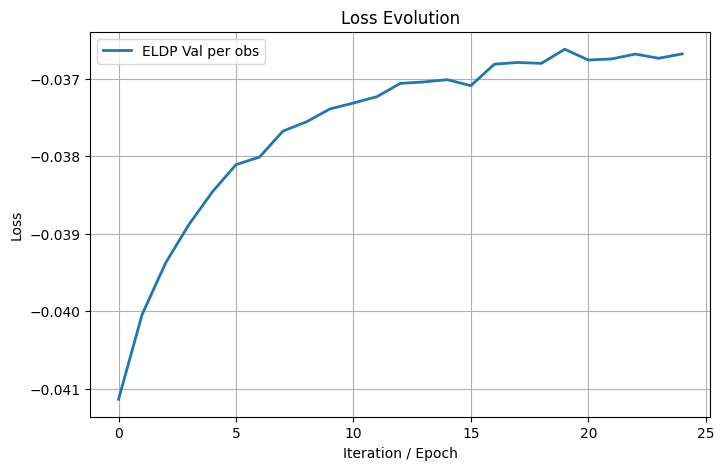

In [11]:
elbo= output['loss_history']
#loss_history = output['ll_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(val_loss, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0386
KLD GTM      Train Data:  0.0269
KLD Gaussian Train Data:  0.1094
KLD Copula   Train Data:  -0.0009

KLD BGTM      Test  Data:  0.0436
KLD GTM      Test  Data:  0.0282
KLD Gaussian Test  Data:  0.1113
KLD Copula   Test  Data:  0.001


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [17]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

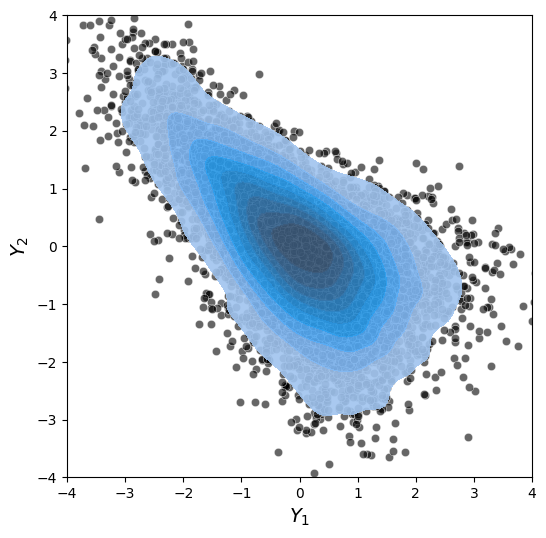

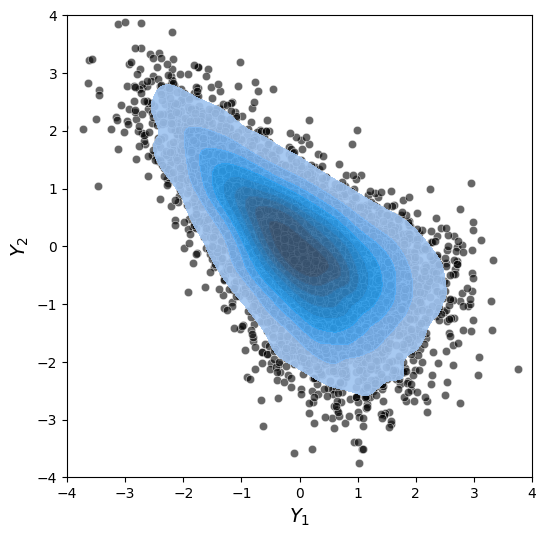

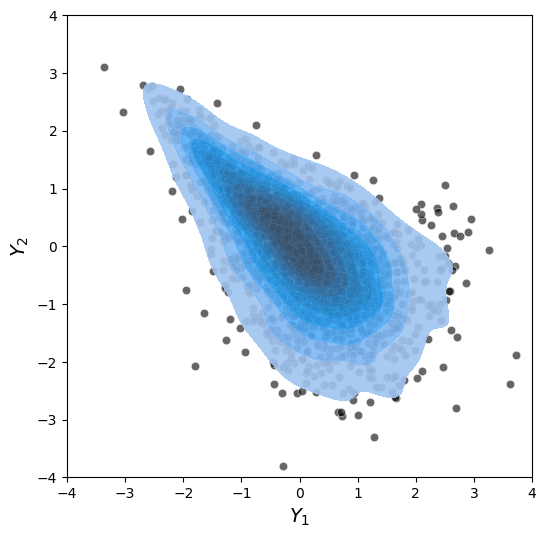

In [18]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [17]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [18]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


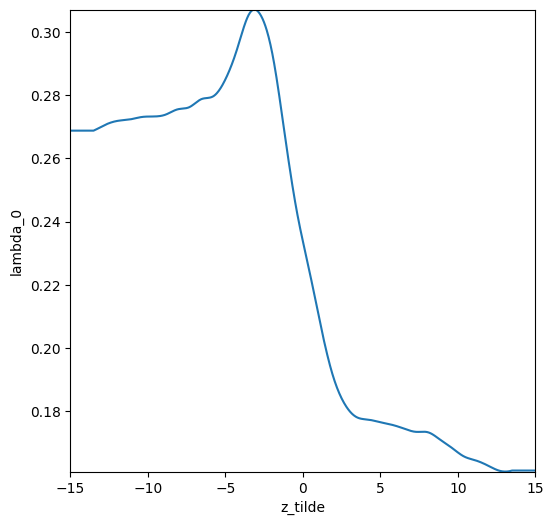

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


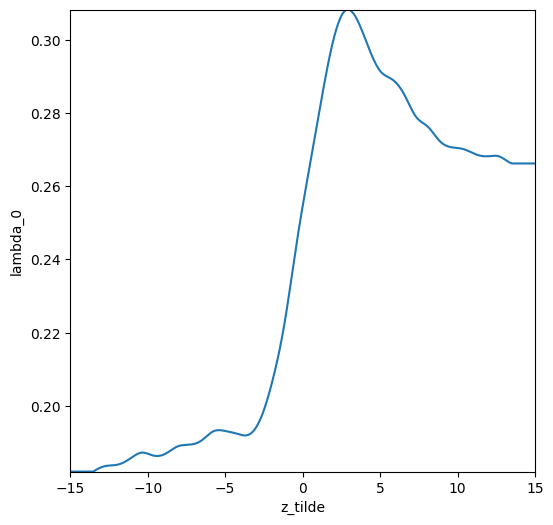

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


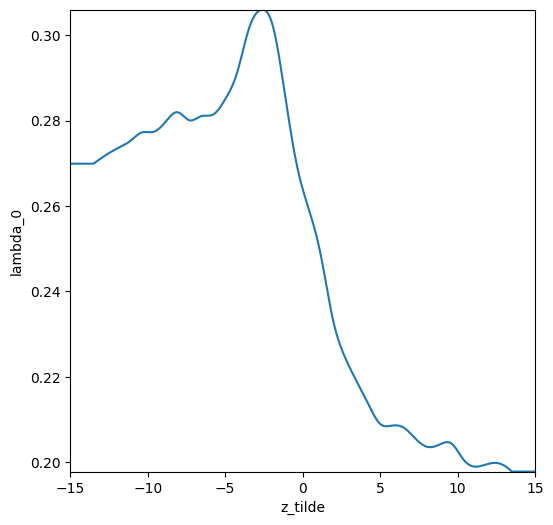

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)